## Import libraries

In [1]:
# Jupyter notebook magic command for inline plotting
%matplotlib inline

# Import libraries
import numpy as np
import sys
import xarray as xr
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr
import glob
import warnings
import os
import pandas as pd
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ECCOv4-py library for ocean state estimates
from os.path import join, expanduser

# Add ECCOv4-py to the system path
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir, 'ECCOv4-py'))
import ecco_v4_py as ecco

# Set up Jupyter notebook display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Display the library versions
print("Library versions:")
print(f"NumPy version: {np.__version__}")
print(f"Xarray version: {xr.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Scipy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Library versions:
NumPy version: 1.26.0
Xarray version: 2023.9.0
Matplotlib version: 3.7.2
Scipy version: 1.26.0
Pandas version: 2.0.3


## Load GRACE Data for Analysis 

In [2]:
# Define the timeframe for analysis
start_date = '2010'
end_date = '2016'

# Set the top-level directory
usb_drive_path = "/Volumes/Liliana"

# Define the ECCO directory
ECCO_dir = os.path.join(usb_drive_path, 'ECCO_V4r4_PODAAC')

# Create a list of GRACE files
grace_files = glob.glob(join(ECCO_dir, '*GRD*', '*.nc'))

# Function to load and concatenate multiple files into a single dataset
def ds_load_concat(file_list, dim_concat):
    for count, file in enumerate(file_list):
        if count == 0:
            ds_out = xr.open_dataset(file)
        else:
            ds_curr = xr.open_dataset(file)
            ds_out = xr.concat((ds_out, ds_curr), dim=dim_concat)
    return ds_out

# Load and concatenate OBP GRACE files 
ds_OBP_grace = ds_load_concat(grace_files, dim_concat='time').sortby('time')

# Filter data based on the specified timeframe
ds_OBP_grace_filtered = ds_OBP_grace.sel(time=slice(str(start_date), str(end_date)))

# Sort the dataset by the resampled time dimension
OBP_anomaly_grace = ds_OBP_grace_filtered.sortby('time')

## Load ECCO Data for Analysis

In [3]:
# Load ECCO Data - Timeframe = '2010-2016' -> Data chosen to be analyzed
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir, '*GEOMETRY*', '*.nc'))[0])

# Load data - Timeframe = '2010-2016' - Data chosen to be analyzed
OBP_monthly_files = glob.glob(join(ECCO_dir, '*OBP*LLC0090GRID*MONTHLY*', '*_201[0-6]-??_*.nc'))

# Load each file into memory 
def ds_load_concat(file_list, dim_concat, vars_to_drop):
    for count, file in enumerate(file_list):
        if count == 0:
            ds_out = xr.open_dataset(file).drop_vars(vars_to_drop)
        else:
            ds_curr = xr.open_dataset(file).drop_vars(vars_to_drop)
            ds_out = xr.concat((ds_out, ds_curr), dim=dim_concat)
    return ds_out

# Create a new dataset by loading, concatenating, and cleaning the OBP_monthly_files.
ds_OBP_monthly = ds_load_concat(OBP_monthly_files, dim_concat='time', vars_to_drop=['OBPGMAP', 'PHIBOT'])

# Sort dataset by resampled time dimension
ds_OBP_monthly = ds_OBP_monthly.sortby('time')

# Merge two datasets 'ecco_grid' and 'ds_OBP_monthly'
ecco_monthly_ds = xr.merge((ecco_grid, ds_OBP_monthly))

##Load ECCO Data - Timeframe = '2002-2016' -> Data used for corrections
OBP_monthly_files_2 = glob.glob(join(ECCO_dir, '*OBP*LLC0090GRID*MONTHLY*', '*_200[2-9]-??_*.nc'))

# Create a new dataset by loading, concatenating, and cleaning the OBP_monthly_files_2.
ds_OBP_monthly_2 = ds_load_concat(OBP_monthly_files_2, dim_concat='time', vars_to_drop=['OBPGMAP', 'PHIBOT'])

# Sort dataset by resampled time dimension
ds_OBP_monthly_2 = ds_OBP_monthly_2.sortby('time')

# Merge two datasets 'ecco_grid' and 'ds_OBP_monthly' | 'ecco_monthly_ds_2' and 'ecco_monthly_ds' 
ecco_monthly_ds_2 = xr.merge([xr.merge((ecco_grid, ds_OBP_monthly_2)), ecco_monthly_ds])

## ECCO - Correction

In [4]:
# Determination of the Total Ocean Area
ocean_mask = np.ceil(ecco_monthly_ds.hFacC)
ocean_mask = ocean_mask.where(ocean_mask == 1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA * ocean_mask[0, :])

# Removing area-weighted global mean values 
OBP_global_mean_mon = (ecco_monthly_ds.OBP * ecco_monthly_ds.rA).sum(dim=['i', 'j', 'tile']) / total_ocean_area
OBP_corrected = ecco_monthly_ds.OBP - OBP_global_mean_mon

# Remove time-mean 2002-2016 field from ECCO  - to be cohesive with GRACE satellite data
OBP_global_mean_mon_2 = (ecco_monthly_ds_2.OBP * ecco_monthly_ds.rA).sum(dim=['i', 'j', 'tile']) / total_ocean_area
OBP_corrected_2 = ecco_monthly_ds_2.OBP - OBP_global_mean_mon_2
OBP_anomaly = OBP_corrected - OBP_corrected_2.mean(dim=['time'])

# Interpolation to a 1° latitude-longitude grid
new_grid_delta_lat = 1
new_grid_delta_lon = 1
new_grid_min_lat = -90
new_grid_max_lat = 90
new_grid_min_lon = -180
new_grid_max_lon = 180

OBP_anomaly_1_degree = np.zeros((84, 180, 360))

for m in range(84):
    new_grid_lon_centers, new_grid_lat_centers, \
    new_grid_lon_edges, new_grid_lat_edges, \
    field_nearest_1deg = \
        ecco.resample_to_latlon(OBP_anomaly.XC, OBP_anomaly.YC, OBP_anomaly.isel(time=m), \
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat, \
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon, \
                                fill_value=np.NaN, \
                                mapping_method='nearest_neighbor', radius_of_influence=120000)
    OBP_anomaly_1_degree[m, :] = field_nearest_1deg

OBP_anomaly_corrected = xr.DataArray(OBP_anomaly_1_degree, name='OBP_anomaly_1_degree',
                                     dims=['time', 'latitude', 'longitude'],
                                     coords={'latitude': new_grid_lat_centers[:, 0],
                                             'longitude': new_grid_lon_centers[0, :],
                                             'time': OBP_anomaly.time})

# Intercept latitude, longitude, and time values with grace date
OBP_anomaly_corrected['longitude'] = (OBP_anomaly_corrected['longitude'] + 360) % 360
OBP_anomaly_corrected_lon = OBP_anomaly_corrected.interp(latitude=OBP_anomaly_grace.lat,
                                                           longitude=OBP_anomaly_grace.lon)
OBP_anomaly_ecco = OBP_anomaly_corrected_lon.interp(time=OBP_anomaly_grace.time)

## ECCO vs GRACE: Determination of Correlation Coefficients

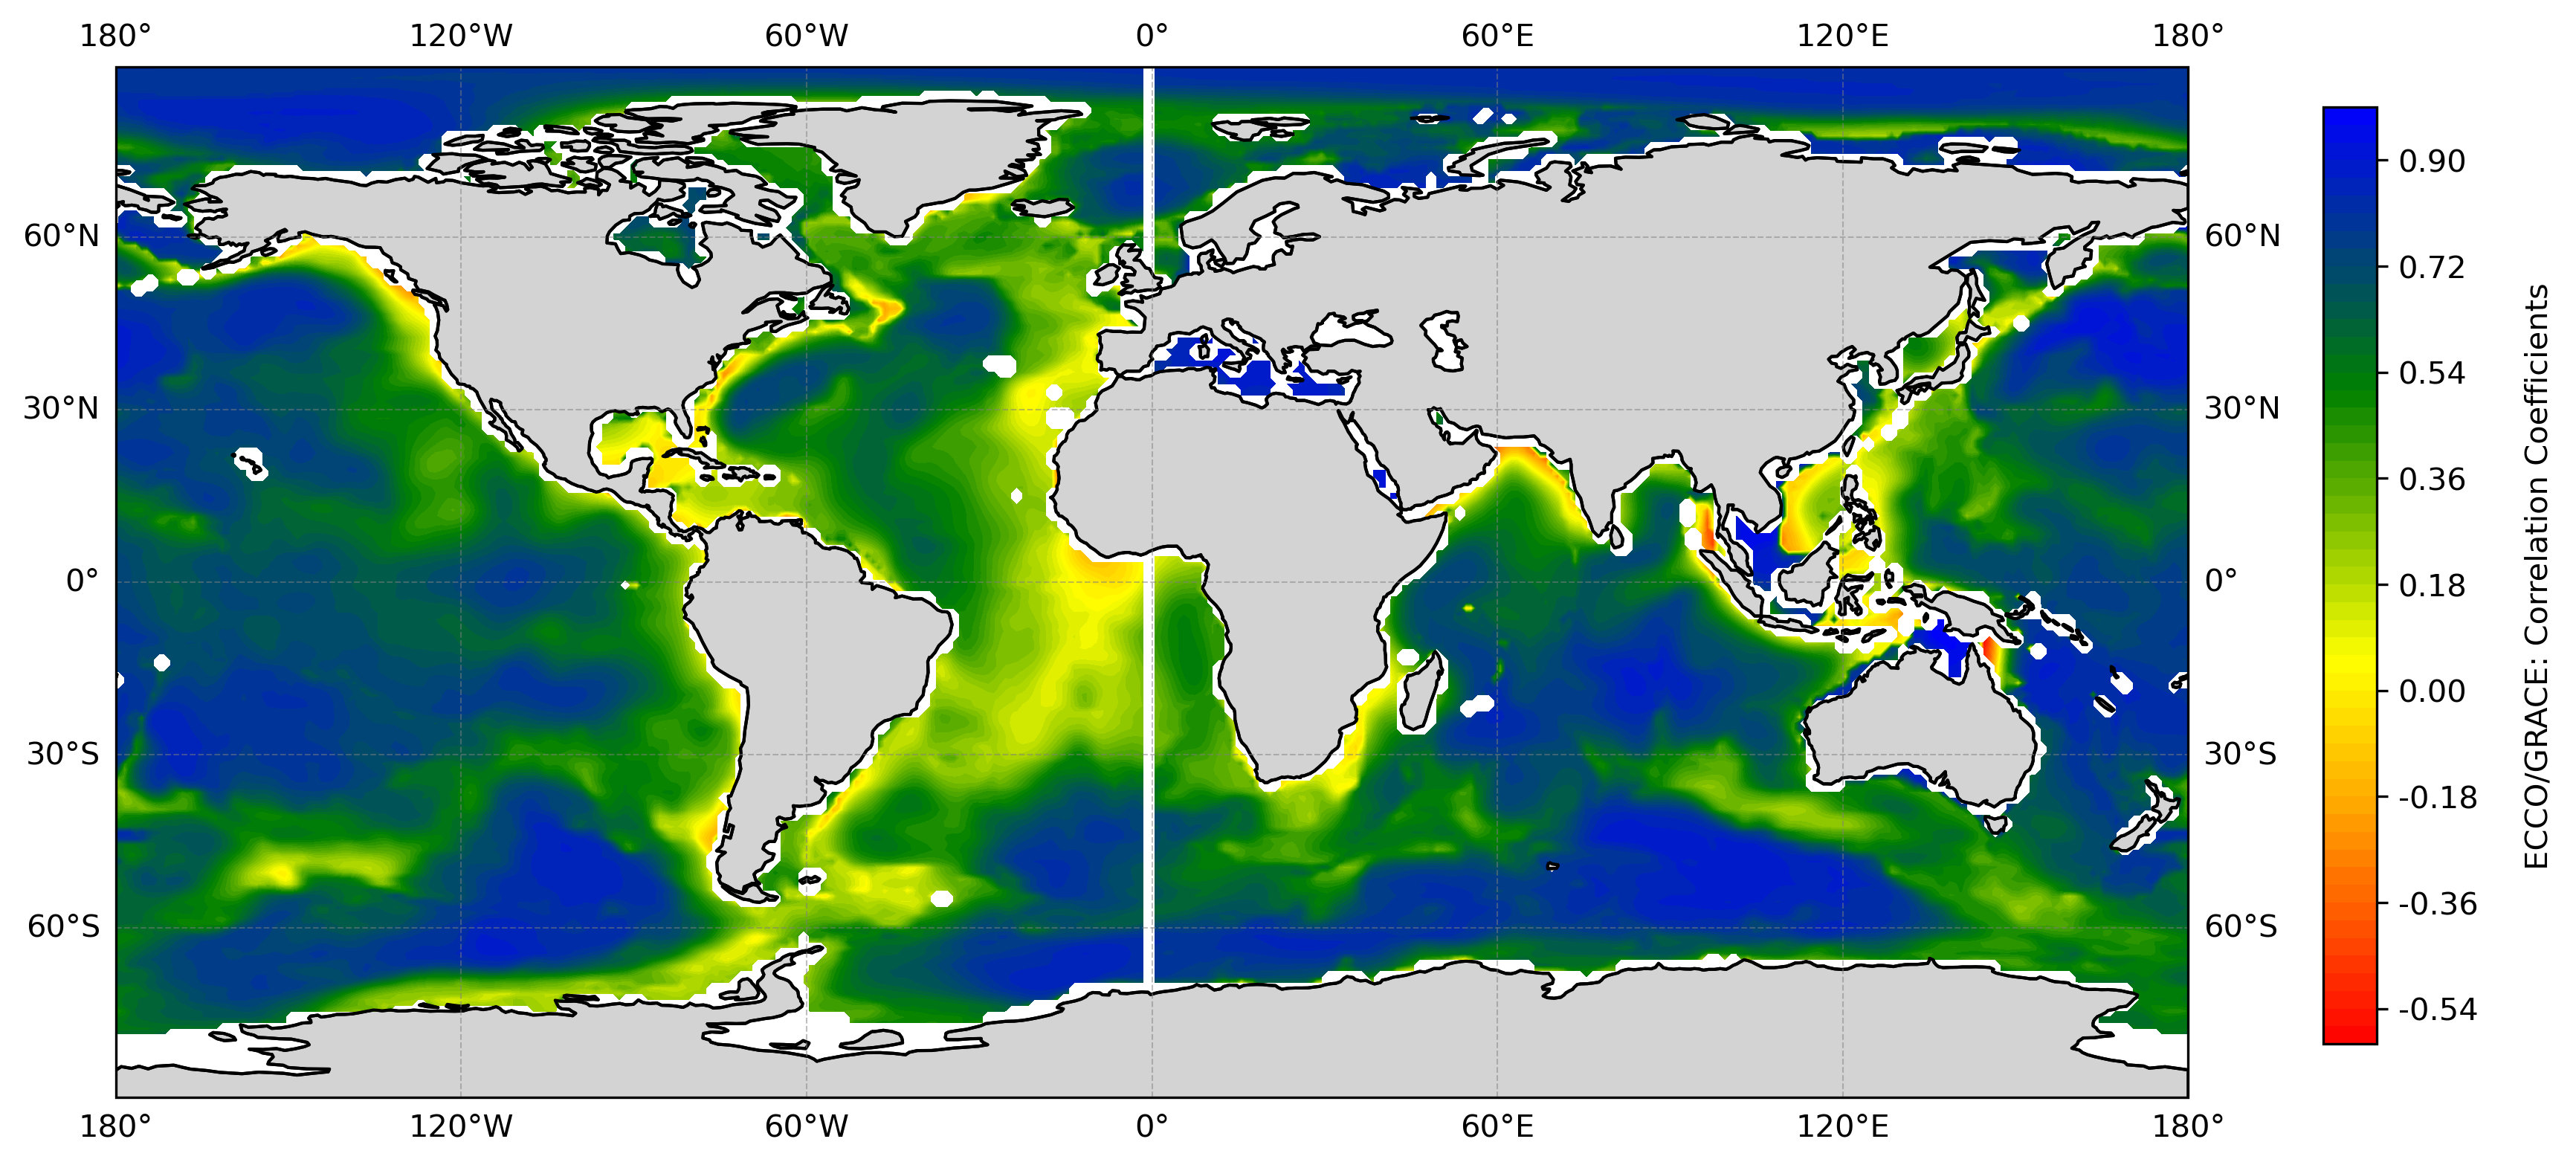

In [5]:
# Determination of correlation coefficients
correlation_coefficient = xr.corr(OBP_anomaly_grace['lwe_thickness'], OBP_anomaly_ecco, dim='time')

# Create a figure with specified size and dpi
fig = plt.figure(figsize=(12, 6), dpi=300)

# Set the projection for the plot as Plate Carrée
ax = plt.axes(projection=ccrs.PlateCarree())

# Specify data for plotting
x = correlation_coefficient.lon
y = correlation_coefficient.lat
tile_to_plot = correlation_coefficient 

# Define a diverging colormap with additional colors
cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 'red'), (0.25, 'orange'), (0.41, 'yellow'), (0.7, 'green'), (1, 'blue')]
)

# Plot filled contours with the custom colormap
cf = plt.contourf(x, y, tile_to_plot, 60, transform=ccrs.PlateCarree(), cmap=cmap)

# Add gridlines on the plot with specified properties
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Add coastlines to the plot
ax.coastlines()

# Add land feature to the plot
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# Add title and labels with increased spacing
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add a colorbar to the plot without overlapping the main plot
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # Adjusted position
cbar = plt.colorbar(cf, ax=ax, cax=cbar_ax, format='%.2f')  # Format colorbar tick labels to two decimal places
cbar.set_label('ECCO/GRACE: Correlation Coefficients', labelpad=15)  # Increased spacing for colorbar title

# Save the plot
plt.savefig('correlation_coefficients_plot.png')

# Display the plot
plt.show()

## ECCO vs GRACE: Determination of Standard Deviation


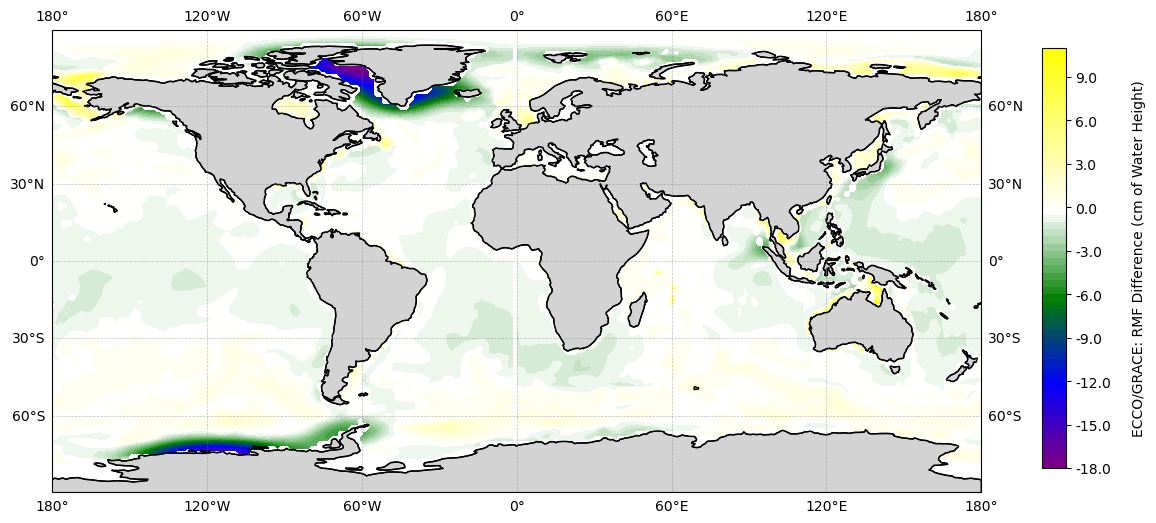

In [6]:
# Calculate squared differences and mean squared differences
squared_diff_grace = (OBP_anomaly_grace.lwe_thickness) ** 2
mean_squared_diff_grace = squared_diff_grace.mean(dim='time')
std_dev_grace = np.sqrt(mean_squared_diff_grace)

squared_diff_ecco = (OBP_anomaly_ecco) ** 2
mean_squared_diff_ecco = squared_diff_ecco.mean(dim='time')
std_dev_ecco = np.sqrt(mean_squared_diff_ecco)

# Create a figure with specified size and dpi
fig = plt.figure(figsize=(12, 6), dpi=100)

# Set the projection for the plot as Plate Carrée
ax = plt.axes(projection=ccrs.PlateCarree())

# Calculate the difference in standard deviation between ECCO and GRACE
error = std_dev_ecco - std_dev_grace
x = error.lon
y = error.lat
tile_to_plot = error.values * 100

# Define a diverging colormap with additional colors
cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 'purple'), (0.2, 'blue'), (0.4, 'green'), (0.61, 'white'), (1, 'yellow')]
)

# Plot filled contours with the custom colormap
cf = plt.contourf(x, y, tile_to_plot, 60, transform=ccrs.PlateCarree(), cmap=cmap)

# Add gridlines on the plot with specified properties
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Add coastlines to the plot
ax.coastlines()

# Add land feature to the plot
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# Add title and labels with increased spacing
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add a colorbar to the plot without overlapping the main plot
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # Adjusted position
cbar = plt.colorbar(cf, ax=ax, cax=cbar_ax, format='%.1f')  # Format colorbar tick labels to one decimal place
cbar.set_label('ECCO/GRACE: RMF Difference (cm of Water Height)', labelpad=15)  # Increased spacing for colorbar title

# Save the plot
plt.savefig('standard_deviation_difference_plot.png')

# Display the plot
plt.show()


## GRACE: Standard Desviation Results

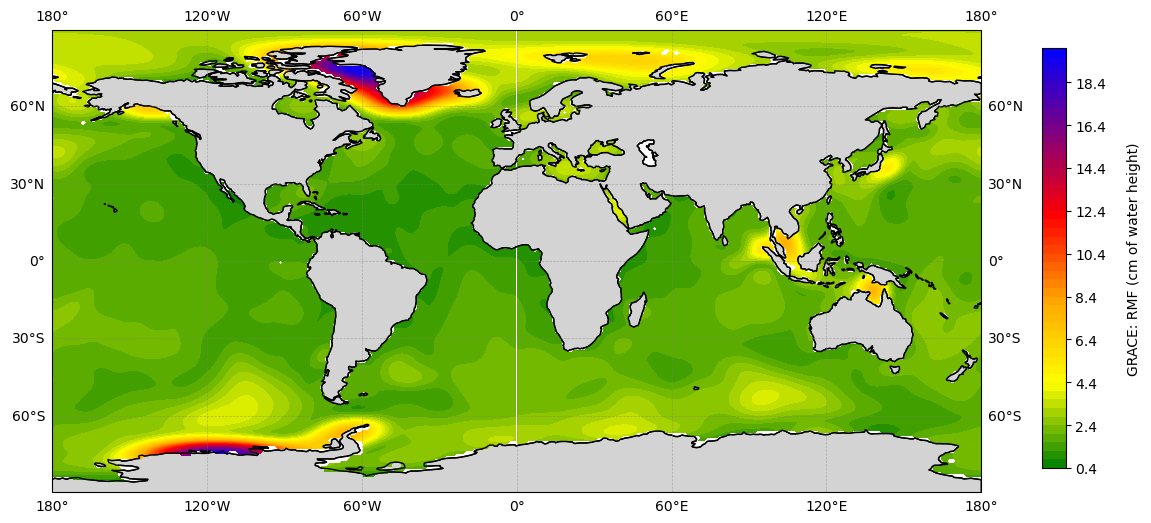

In [7]:
# Create a figure with a specified size and dpi
fig = plt.figure(figsize=(12, 6), dpi=100)

# Set the projection for the plot as Plate Carrée
ax = plt.axes(projection=ccrs.PlateCarree())

# Specify data for plotting
x = std_dev_grace.lon
y = std_dev_grace.lat
tile_to_plot = std_dev_grace * 100

# Define a diverging colormap with additional colors
cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 'green'), (0.2, 'yellow'), (0.4, 'orange'), (0.6, 'red'), (0.8, 'purple'),  (1, 'blue')]
)

# Plot filled contours with the custom colormap
cf = plt.contourf(x, y, tile_to_plot, 60, transform=ccrs.PlateCarree(), cmap=cmap)

# Add gridlines on the plot with specified properties
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Add coastlines to the plot
ax.coastlines()

# Add land feature to the plot
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# Add title and labels with increased spacing
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add a colorbar to the plot without overlapping the main plot
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # Adjusted position
cbar = plt.colorbar(cf, ax=ax, cax=cbar_ax, format='%.1f')  # Format colorbar tick labels to two decimal places
cbar.set_label('GRACE: RMF (cm of water height)', labelpad=15)  # Increased spacing for colorbar title

# Save the plot
plt.savefig('grace.png')

# Display the plot
plt.show()

## ECCO: Standard Desviation Results

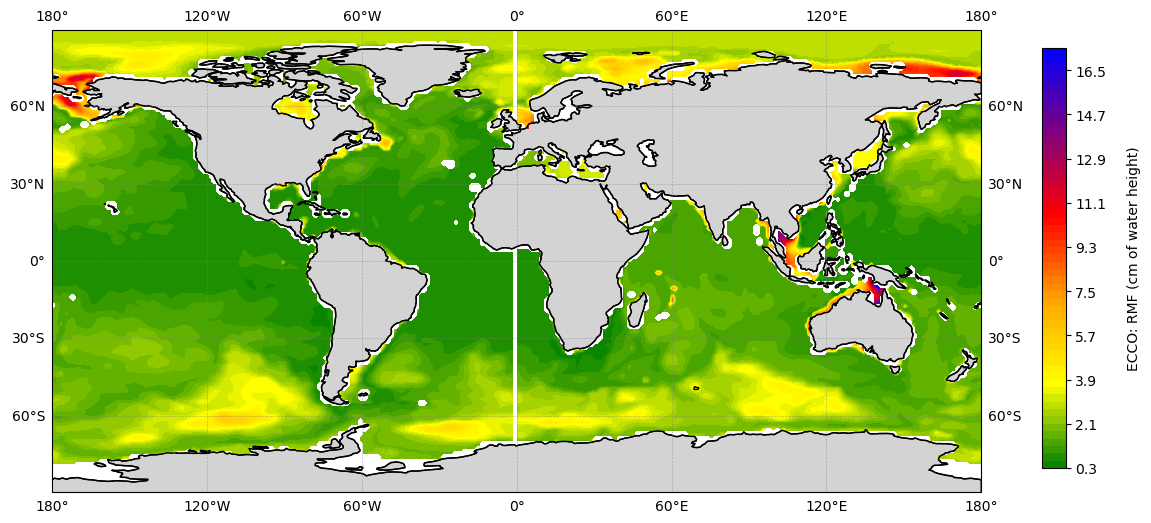

In [8]:
# Create a figure with a specified size and dpi
fig = plt.figure(figsize=(12, 6), dpi=100)

# Set the projection for the plot as Plate Carrée
ax = plt.axes(projection=ccrs.PlateCarree())

# Specify data for plotting
x = std_dev_ecco.lon
y = std_dev_ecco.lat
tile_to_plot = std_dev_ecco *100

# Define a diverging colormap with additional colors
cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 'green'), (0.2, 'yellow'), (0.4, 'orange'), (0.6, 'red'), (0.8, 'purple'),  (1, 'blue')]
)

# Plot filled contours with the custom colormap
cf = plt.contourf(x, y, tile_to_plot, 60, transform=ccrs.PlateCarree(), cmap=cmap)

# Add gridlines on the plot with specified properties
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Add coastlines to the plot
ax.coastlines()

# Add land feature to the plot
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# Add title and labels with increased spacing
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add a colorbar to the plot without overlapping the main plot
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # Adjusted position
cbar = plt.colorbar(cf, ax=ax, cax=cbar_ax, format='%.1f')  # Format colorbar tick labels to two decimal places
cbar.set_label('ECCO: RMF (cm of water height)', labelpad=15)  # Increased spacing for colorbar title

# Save the plot
plt.savefig('ecco.png')

# Display the plot
plt.show()